#### Set up
Run this section before anything else

In [135]:
from datetime import datetime, timedelta
import Dataloader_ricequant as dl
import pandas as pd
import rqdatac as rq
from constants import *
import scipy
import statsmodels as sm
import numpy as np
import seaborn as sns
import pathos
from tqdm.notebook import tqdm
import multiprocessing
import pickle

In [136]:
def applyParallel(dfGrouped, func):
    #parrallel computing version of pd.groupby.apply, works most of the time but not always
    #I mainly use it for cases where func takes in a dataframe and outputs a dataframe or a series
    with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool:
        ret_list = pool.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [137]:
dl.rq_initialize()

C:\Users\jiyic\anaconda3\envs\multifactor\lib\site-packages\rqdatac\client.py:197: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
C:\Users\jiyic\anaconda3\envs\multifactor\lib\site-packages\rqdatac\client.py:236: UserWarning: Your account will be expired after  141 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


In [138]:
def sort_index_and_col(df) -> pd.DataFrame:
    #sort the dataframe by index and column
    return df.sort_index(axis=0).reindex(sorted(df.columns), axis=1)
    #the following might achieve the same result in a cleaner way
    # return df.sort_index(axis=0).sort_index(axis=1)

In [139]:
results = dl.load_basic_info()

## Load Industry Data

In [140]:
df_indus_mapping = dl.load_industry_mapping()

## TBD: Load Index Data
### In hiearachical backtesting we need weights of index(沪深300，中证500 etc.) data to make the portfolio to stay industry-neutral with the index
### Currently index data is assumed to be uniformly weighted among all stocks

In [141]:
# index_weights_by_date = []
# for date in tqdm(pd.date_range(START_DATE, END_DATE, freq='B')):
#     index_weights = rq.index_weights('000016.XSHG', date)
#     index_weights_by_date.append(index_weights)

#### Data Preprocessing

Major Steps: 

0) Read all csv's and concatenate the desired column from each dataframe
1) Filter out data before START_DATE and after END_DATE(backtesting period) from the raw stock data. 
剔除不在回测区间内的股票信息
2) Filter listed stocks
选出回测区间内每只股票上市的时间。这一步是为了步骤3，因为在每个选股日筛选ST或者停牌股的前提是股票在该选股日已上市。
3) Filter out ST stocks, suspended stocks and stocks that are listed only within one year
剔除ST，停牌和次新股（上市未满一年的股票）


In [142]:
# step 0
df_backtest = pd.concat(results, axis=0).rename(columns={'code': 'stock'}).loc[:, INDEX_COLS + BASIC_INFO_COLS]
df_backtest['date'] = pd.to_datetime(df_backtest['date'])

# step 1
df_backtest = df_backtest[ (START_DATE <= df_backtest['date']) & (df_backtest['date'] <= END_DATE) ]
df_backtest['stock'] = df_backtest['stock'].apply(lambda stock: dl.normalize_code(stock))

# have a (date_stock) multi-index dataframe 
df_backtest = df_backtest.set_index(INDEX_COLS).sort_index()
df_backtest = df_backtest.unstack(level=1).stack(dropna=False)

In [143]:
# check stock index
stock_names = df_backtest.index.get_level_values(1).unique()
stock_names

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '688668.XSHG', '688678.XSHG', '688679.XSHG', '688686.XSHG',
       '688698.XSHG', '688699.XSHG', '688777.XSHG', '688788.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='stock', length=4196)

In [144]:
# with open('./Data/raw_data/stock_names.h5', 'wb') as fp:
#     pickle.dump(stock_names, fp)

In [145]:
with open('./Data/raw_data/stock_names.h5', 'rb') as fp:
     stock_names = pickle.load(fp)

In [146]:
# step 2
# get the listed date
listed_dates = {dl.normalize_code(result['code'][0]): result['date'].min() for result in results}
listed_dates = pd.DataFrame(pd.Series(listed_dates), columns=['listed_date']).sort_index()
# left join with dataframe 'listed_dates'
df_backtest = df_backtest.merge(listed_dates, left_on = 'stock', right_index=True, how='left')
# create a new variable called 'is_listed' to check if a certain stock is listed at that given date
df_backtest['is_listed'] = (df_backtest.index.get_level_values(level=0) >= df_backtest['listed_date'])

In [147]:
len(df_backtest.loc['2011-01-04'])

4196

In [148]:
len(listed_dates)

4560

UNSOLVED: 4196≠4560 Where does this difference in the number of stocks come from?

<AxesSubplot:xlabel='date'>

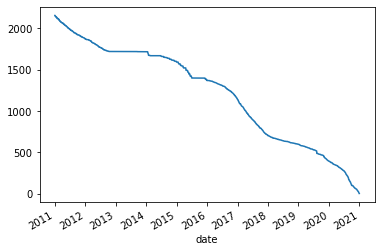

In [149]:
# number of non-listed stocks along the time
non_listed = df_backtest[df_backtest['is_listed'] == False]
num_nonlisted_stock = non_listed.groupby(level=0).count()['is_listed']
num_nonlisted_stock.plot.line()

In [150]:
df_backtest

PE_TTM     PS_TTM      PC_TTM         PB  \
date       stock                                                      
2011-01-04 000001.XSHE   8.865369   3.275312    1.187931   1.736868   
           000002.XSHE  17.143047   2.319354  -30.282091   2.403611   
           000004.XSHE  72.239436   8.031760   71.600273  14.373444   
           000005.XSHE -53.807405  79.472714  165.599447   5.077750   
           000006.XSHE  15.341738   1.899546  269.949866   2.643284   
...                           ...        ...         ...        ...   
2020-12-31 688699.XSHG        NaN        NaN         NaN        NaN   
           688777.XSHG        NaN        NaN         NaN        NaN   
           688788.XSHG        NaN        NaN         NaN        NaN   
           688981.XSHG        NaN        NaN         NaN        NaN   
           689009.XSHG        NaN        NaN         NaN        NaN   

                        market_value    open   close listed_date  is_listed  
date       stock                                                             
2011-01-04 000001.XSHE  5.582992e+10   15.82   16.02  1991-04-03       True  
           000002.XSHE  8.518624e+10    8.27    8.80  1991-01-29       True  
           000004.XSHE  1.015278e+09   12.14   12.09  1991-01-14       True  
           000005.XSHE  3.428751e+09    3.68    3.75  1991-01-04       True  
           000006.XSHE  5.530833e+09    7.05    7.27  1992-04-27       True  
...                              ...     ...     ...         ...        ...  
2020-12-31 688699.XSHG  4.103000e+09   54.00   55.17  2020-12-18       True  
           688777.XSHG  4.922700e+10   99.58  100.20  2020-11-24       True  
           688788.XSHG  1.006900e+10  134.49  133.30  2020-10-22       True  
           688981.XSHG  4.448770e+11   57.00   57.75  2020-07-16       True  
           689009.XSHG  6.042500e+10   82.00   85.82  2020-10-29       True  

[10204672 rows x 9 columns]

In [151]:
# load st/suspend data from Ricequant
df_is_st = dl.load_st_data(stock_names)
df_is_suspended = dl.load_suspended_data(stock_names)

In [152]:
# step 3
#create ST and suspended columns
df_backtest['is_st'] = df_is_st.values
df_backtest['is_suspended'] = df_is_suspended.values
# filter out stocks that are listed within a year
df_backtest = df_backtest[df_backtest['listed_date']<'2020-01-01']
#filter out ST and suspended stocks, filter data by the stock's listed date
df_backtest = df_backtest.loc[ (~df_backtest['is_st']) & (~df_backtest['is_suspended']) & (df_backtest['is_listed']), BASIC_INFO_COLS]
#keep data only on the rebalancing dates
rebalancing_dates = pd.date_range(start=START_DATE, end=END_DATE, freq='BM')
df_backtest = df_backtest[df_backtest.index.get_level_values(0).isin(rebalancing_dates)]

In [153]:
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-12-31 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  
date       stock                                      
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31  
           000002.XSHE  7.937809e+10    8.25    8.20  
           000005.XSHE  3.200168e+09    3.46    3.50  
           000006.XSHE  5.409109e+09    7.15    7.11  
           000009.XSHE  1.937173e+10   17.05   17.76  
...                              ...     ...     ...  
2020-12-31 688368.XSHG  1.060100e+10  159.42  172.09  
           688369.XSHG  5.913000e+09   77.35   76.80  
           688388.XSHG  2.034900e+10   86.90   88.14  
           688389.XSHG  8.866000e+09   21.20   21.00  
           688399.XSHG  1.127500e+10  190.40  192.34  

[307662 rows x 7 columns]

In [154]:
#the current rebalancing date is the last trading day of the current period
#'next_period_open' is defined as the stock's open price on the next relancing date
#'next_period_return' is the generated return by holding a stock from EOD of current rebalancing date to the start of the next rebalancing date
df_backtest['next_period_open'] = df_backtest['open'].groupby(level=1).shift(-1).values
df_backtest['next_period_return'] = (df_backtest['next_period_open'].values - df_backtest['close'].values) / df_backtest['close'].values
df_backtest = df_backtest[df_backtest.index.get_level_values(0) != df_backtest.index.get_level_values(0).max()]

In [155]:
df_preprocess1 = df_backtest

In [156]:
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688368.XSHG           -0.186633  
           688369.XSHG            0.110872  
           688388.XSHG            0.448333  
           688389.XSHG            0.085509  
           688399.XSHG            0.030359  

[304082 rows x 9 columns]

In [157]:
nan = df_backtest.loc['2020-11-30','688368.XSHG'][0]
nan

nan

## Data Preprocessing part 2
### 1) Replace Outliers with the corresponding threshold
### 2) Standardization - Subtract mean and divide by std
### 3) Fill missing values with 0


In [158]:
def remove_outlier(df, n=3, nan=nan):
    #for any factor, if the stock's factor exposure lies more than n times MAD away from the factor's median, 
    # reset that stock's factor exposure to median + n * MAD/median - n* MAD
    med = df.median(axis=0)
    MAD = (df - med).abs().median()
    upper_limit = med + n * MAD
    lower_limit = med - n * MAD
    print(f"lower_limit = {lower_limit}, upper_limit = {upper_limit}")
    #pd.DataFrame.where replaces data in the dataframe by 'other' where the condition is False
    df = df.where((df <= upper_limit) | (df != nan) , other = upper_limit, axis=1)
    df = df.where((df >= lower_limit) | (df != nan), other = lower_limit, axis=1)
    return df

In [159]:
# what is this step used for? Check the number of rebalancing dates?
df_preprocess1.groupby(level=0)[TEST_FACTORS].agg('sum')

,PE_TTM,PS_TTM,PC_TTM,PB
date,,,,
2011-01-31,62284.978367,8294.520947,30147.223650,8833.169464
2011-02-28,71634.246989,8711.615164,25835.173731,9399.392288
2011-03-31,159596.791786,9504.488037,36762.898708,9426.752556
2011-04-29,132727.256506,10209.401039,-18775.133366,8736.007973
2011-05-31,119891.629847,9532.234645,59957.219910,8148.175216
...,...,...,...,...
2020-07-31,313101.734018,17765.949923,84815.728149,14948.160701
2020-08-31,321013.730282,17935.516171,84444.773349,15227.465986
2020-09-30,276967.073128,16305.244345,71375.799088,14045.338750


In [160]:
# step 1
df_preprocess1[TEST_FACTORS] = applyParallel(df_preprocess1[TEST_FACTORS].groupby(level=0), remove_outlier).values

C:\Users\jiyic\anaconda3\envs\multifactor\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [161]:
df_preprocess1

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688368.XSHG           -0.186633  
           688369.XSHG            0.110872  
           688388.XSHG            0.448333  
           688389.XSHG            0.085509  
           688399.XSHG            0.030359  

[304082 rows x 9 columns]

In [162]:
def standardize(df):
    #on each rebalancing date, each standardized factor has mean 0 and std 1
    return (df - df.mean()) / df.std()

df_preprocess1[TEST_FACTORS] = applyParallel(df_preprocess1[TEST_FACTORS].groupby(level=0), standardize).values

C:\Users\jiyic\anaconda3\envs\multifactor\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [163]:
df_preprocess1

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG       NaN       NaN       NaN       NaN  1.207400e+10   
           688369.XSHG       NaN       NaN       NaN       NaN  5.361000e+09   
           688388.XSHG       NaN       NaN       NaN       NaN  1.385300e+10   
           688389.XSHG       NaN       NaN       NaN       NaN  8.246000e+09   
           688399.XSHG       NaN       NaN       NaN       NaN  1.083200e+10   

                          open   close  next_period_open  next_period_return  
date       stock                                                              
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658  
           000002.XSHE    8.25    8.20              8.13           -0.008537  
           000005.XSHE    3.46    3.50              4.28            0.222857  
           000006.XSHE    7.15    7.11              7.22            0.015471  
           000009.XSHE   17.05   17.76             23.50            0.323198  
...                        ...     ...               ...                 ...  
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633  
           688369.XSHG   69.03   69.63             77.35            0.110872  
           688388.XSHG   62.18   60.00             86.90            0.448333  
           688389.XSHG   19.33   19.53             21.20            0.085509  
           688399.XSHG  185.00  184.79            190.40            0.030359  

[304082 rows x 9 columns]

In [164]:
df_preprocess1[TEST_FACTORS] = df_preprocess1[TEST_FACTORS].fillna(0).values

C:\Users\jiyic\anaconda3\envs\multifactor\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [165]:
df_preprocess1

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  
date       stock                                                              
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658  
           000002.XSHE    8.25    8.20              8.13           -0.008537  
           000005.XSHE    3.46    3.50              4.28            0.222857  
           000006.XSHE    7.15    7.11              7.22            0.015471  
           000009.XSHE   17.05   17.76             23.50            0.323198  
...                        ...     ...               ...                 ...  
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633  
           688369.XSHG   69.03   69.63             77.35            0.110872  
           688388.XSHG   62.18   60.00             86.90            0.448333  
           688389.XSHG   19.33   19.53             21.20            0.085509  
           688399.XSHG  185.00  184.79            190.40            0.030359  

[304082 rows x 9 columns]

In [166]:
#data missing issue, simply filter them out, otherwise would negatively impact later results
df_preprocess1 = df_preprocess1[df_preprocess1['next_period_return'].notnull() & df_preprocess1['market_value'].notnull()]

In [167]:
df_backtest = df_preprocess1

In [168]:
df_preprocess1

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  
date       stock                                                              
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658  
           000002.XSHE    8.25    8.20              8.13           -0.008537  
           000005.XSHE    3.46    3.50              4.28            0.222857  
           000006.XSHE    7.15    7.11              7.22            0.015471  
           000009.XSHE   17.05   17.76             23.50            0.323198  
...                        ...     ...               ...                 ...  
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633  
           688369.XSHG   69.03   69.63             77.35            0.110872  
           688388.XSHG   62.18   60.00             86.90            0.448333  
           688389.XSHG   19.33   19.53             21.20            0.085509  
           688399.XSHG  185.00  184.79            190.40            0.030359  

[301709 rows x 9 columns]

# Single-Factor Backtesting

同一类风格因子选多个(5-10)集中测试，下面是常见的几种测试方法，对于每一个方法相应的不同评价指标，我们最后用折线图/柱状图和一张完整的表格/dataframe来展示，详见华泰研报单因子测试中的任意一篇

- 回归法
- IC值
- 分层回测（既要与基准组合比较，也要比较超额收益的时间序列）

In [169]:
SINGLE_FACTOR = 'PE_TTM'

# T-Value Analysis

In [172]:
def wls_tval_coef(df):
    #obtain the t-value in WLS of the tested factor
    # 函数内需要用包要额外在这里加上
    import statsmodels.formula.api as smf
    import pandas as pd
    SINGLE_FACTOR = 'PE_TTM'
    wls_result = smf.wls(formula = f"next_period_return ~ 0 + {SINGLE_FACTOR}", 
                    data=df, weights = df['market_value'] ** 0.5).fit()
    result_tval_coef = pd.Series( {'t_value': wls_result.tvalues.values[0], 'coef': wls_result.params.values[0], 
                         } )
    # result_resid = pd.Series( {'resid': wls_result.resid.values} )
    return result_tval_coef.to_frame().transpose()

In [229]:
#get the t-value for all periods
wls_results_tval_coef = applyParallel(df_backtest.groupby(level=0), wls_tval_coef)
wls_results_tval_coef.index = df_backtest.index.get_level_values(level=0).unique()
wls_results_tval_coef[wls_results_tval_coef['t_value']>2]

,t_value,coef
date,,
2012-07-31,2.533741,0.011748
2014-02-28,2.794047,0.011731


In [174]:
#get a summary result from the t-value series
tval_series_mean = wls_results_tval_coef['t_value'].abs().mean()
large_tval_prop = (wls_results_tval_coef['t_value'].abs() > 2).sum() / wls_results_tval_coef.shape[0]
standardized_tval = wls_results_tval_coef['t_value'].mean() / wls_results_tval_coef['t_value'].std()
coef_series_mean = wls_results_tval_coef['coef'].mean()
coef_series_t_val = scipy.stats.ttest_1samp(wls_results_tval_coef['coef'], 0).statistic

In [175]:
print(tval_series_mean, large_tval_prop, standardized_tval, coef_series_mean, coef_series_t_val)

0.6613767399522356 0.017857142857142856 -0.052696603927778446 -0.00015412094207240944 -0.5863674700121675


## Information Coefficient Analysis

In [36]:
#Rank IC is defined by the spearman correlation of the factor residual(after market-value and industry neutralizations)
#with next period's return

In [176]:
df_backtest = df_backtest.merge(df_indus_mapping, how='left', left_on='stock', right_index=True)

In [177]:
print(df_backtest.shape)
df_backtest = df_backtest[df_backtest['pri_indus_code'].notnull()]
print(df_backtest.shape)

(301709, 11)
(297489, 11)


In [178]:
def wls_factor_resid(df):
    import statsmodels.formula.api as smf
    wls_result = smf.wls(formula = f"PE_TTM ~ 0 + market_value + C(pri_indus_code)", 
                    data=df, weights = df['market_value'] ** 0.5).fit()
    return wls_result.resid

In [179]:
df_backtest.shape

(297489, 11)

In [180]:
factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
factor_resids = factor_resids.rename('PE_TTM_resid')
factor_resids

date        stock      
2011-01-31  000001.XSHE   -0.011673
            000002.XSHE   -0.028798
            000005.XSHE    0.019206
            000006.XSHE   -0.030260
            000009.XSHE   -0.016860
                             ...   
2020-11-30  688368.XSHG   -0.181082
            688369.XSHG   -0.181147
            688388.XSHG    0.000701
            688389.XSHG    0.000647
            688399.XSHG    0.000672
Name: PE_TTM_resid, Length: 297489, dtype: float64

In [181]:
df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)

In [182]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  PE_TTM_resid  
date       stock                                                      
2011-01-31 000001.XSHE              J66              J     -0.011673  
           000002.XSHE              K70              K     -0.028798  
           000005.XSHE              N77              N      0.019206  
           000006.XSHE              K70              K     -0.030260  
           000009.XSHE              S90              S     -0.016860  
...                                 ...            ...           ...  
2020-11-30 688368.XSHG              I65              I     -0.181082  
           688369.XSHG              I65              I     -0.181147  
           688388.XSHG              C39              C      0.000701  
           688389.XSHG              C35              C      0.000647  
           688399.XSHG              C27              C      0.000672  

[297489 rows x 12 columns]

In [183]:
def cross_sectional_ic(df):
    return df[['next_period_return', 'PE_TTM_resid']].corr(method='spearman').iloc[0, 1]
ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)

In [184]:
ic_series

date
2011-01-31    0.122038
2011-02-28   -0.108788
2011-03-31   -0.039691
2011-04-29    0.044145
2011-05-31   -0.005144
                ...   
2020-07-31   -0.070473
2020-08-31   -0.013264
2020-09-30   -0.039684
2020-10-30   -0.032101
2020-11-30    0.078700
Length: 112, dtype: float64

In [185]:
ic_series_mean = ic_series.mean()
ic_series_std = ic_series.std()
ir = ic_series_mean / ic_series_std
ic_series_cum = ic_series.cumsum()
ic_pos_prop = (ic_series > 0).sum() / ic_series.shape[0]

In [186]:
print(f"ic_series_mean = {ic_series_mean}")
print(f"ic_series_std = {ic_series_std}")
print(f"ir = {ir}")
print(f"ic_series_cum = \n{ic_series_cum}")
print(f"ic_pos_prop = {ic_pos_prop}")

ic_series_mean = -0.01126503778743279
ic_series_std = 0.07514772339978255
ir = -0.1499052436692365
ic_series_cum = 
date
2011-01-31    0.122038
2011-02-28    0.013250
2011-03-31   -0.026441
2011-04-29    0.017703
2011-05-31    0.012559
                ...   
2020-07-31   -1.255335
2020-08-31   -1.268599
2020-09-30   -1.308283
2020-10-30   -1.340384
2020-11-30   -1.261684
Length: 112, dtype: float64
ic_pos_prop = 0.44642857142857145


<AxesSubplot:xlabel='date'>

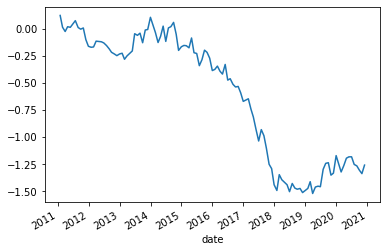

In [187]:
ic_series_cum.plot()

In [188]:
df_backtest = df_backtest.drop(columns = ['PE_TTM_resid'])

## Hiearachical Backtesting

In [189]:
NUM_GROUPS = 5
GROUP_NAMES = [f"group{i}_weight" for i in range(1, NUM_GROUPS + 1)]

In [190]:
from functools import partial
assigned_group = df_backtest.groupby('pri_indus_code')['PE_TTM'].apply(partial(pd.qcut, q=5, labels=range(5)))

In [191]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  
date       stock                                        
2011-01-31 000001.XSHE              J66              J  
           000002.XSHE              K70              K  
           000005.XSHE              N77              N  
           000006.XSHE              K70              K  
           000009.XSHE              S90              S  
...                                 ...            ...  
2020-11-30 688368.XSHG              I65              I  
           688369.XSHG              I65              I  
           688388.XSHG              C39              C  
           688389.XSHG              C35              C  
           688399.XSHG              C27              C  

[297489 rows x 11 columns]

In [192]:
df_backtest[df_backtest.index.get_level_values(0) == '2011-01-31'].groupby('pri_indus_code')['PE_TTM'].count()

pri_indus_code
A      28
B      54
C    1038
D      78
E      45
F     107
G      67
H       6
I     107
J      60
K      94
L      32
M       7
N      25
P       3
Q      10
R      22
S      12
Name: PE_TTM, dtype: int64

In [193]:
#Here for simplicity we assume that index weight is a uniform portfolio over all stocks, to be modified later
df_backtest['index_weight'] = df_backtest.groupby(level=0).apply(lambda df: pd.Series([1/df.shape[0]] * df.shape[0])).values

In [194]:
#merge the industry weights of the index onto the backtesting dataframe
def set_index_indus_weight(df):
    index_indus_weight = df.groupby('pri_indus_code')['index_weight'].sum().rename('index_indus_weight')
    df = df.merge(index_indus_weight, how='left', left_on='pri_indus_code', right_index=True)
    return df
#'index_indus_weight' = this stock's industry weight in the benchmark index
if 'index_indus_weight' not in df_backtest.columns:
    df_backtest = applyParallel(df_backtest.groupby(level=0), set_index_indus_weight)

In [195]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  
date       stock                            
2011-01-31 000001.XSHE            0.033426  
           000002.XSHE            0.052368  
           000005.XSHE            0.013928  
           000006.XSHE            0.052368  
           000009.XSHE            0.006685  
...                                    ...  
2020-11-30 688368.XSHG            0.080820  
           688369.XSHG            0.080820  
           688388.XSHG            0.627775  
           688389.XSHG            0.627775  
           688399.XSHG            0.627775  

[297489 rows x 13 columns]

In [196]:
import numpy as np
# hiearchical backtesting is pretty hard to implement using purely vectorization/parrallelization, and I have to use for loop at least once.
def get_group_weight_by_industry(num_stocks, num_groups) -> np.array:
    """
    precondition: the stocks need to be sorted by factor exposure
    @num_stocks: the number of stocks in this industry
    @num_groups: the number of portfolio groups to be constructed
    
    returns: an intermediary (num_stocks x num_groups) weight matrix specifying the weight of 
             each stock in each group. Here weights within each group(column sum) adds up to 1.
             This is not the final weight matrix because there are many industries(so that weights within 
             each group should actually be smaller than one) but the returned
             weight matrix represents only one industry. 
    
    if you want to understand the algorithm deeper, print some intermediary outputs
    """
    num_rows = min(num_groups, num_stocks)
    num_cols = max(num_groups, num_stocks)
    weight_mat = np.zeros((num_rows, num_cols))
    remaining = 0
    j = 0
    row_budget = num_cols
    col_budget = num_rows
    for i in range(num_rows):
        # print(f"i = {i}")
        start = col_budget - remaining
        # print(f"start = {start}")
        weight_mat[i, j] = start
        offset = (row_budget - start) // col_budget
        # print(f"offset = {offset}")
        weight_mat[i, j + 1: j + 1 + offset] = col_budget
        remaining = row_budget - offset * col_budget - start
        j = j + 1 + offset
        if j < num_cols:
            weight_mat[i, j] = remaining
        
    weight_mat = weight_mat if num_groups > num_stocks else weight_mat.transpose()
    weight_mat_normalized = weight_mat / weight_mat.sum(axis=0)
    return weight_mat_normalized

def get_weight_df_by_industry(df: pd.DataFrame) -> pd.DataFrame:
    """get the weight dataframe for each industry"""
    #sort by the factor exposure
    df = df.sort_values(by='PE_TTM') 
    stock_names = df.index.get_level_values(1)
    #get weight matrix first
    weight_mat = get_group_weight_by_industry(stock_names.shape[0], NUM_GROUPS)
    df[GROUP_NAMES] = weight_mat
    return df

In [197]:
def get_group_weight_by_date(df_backtest_sub):
    #get the intermediary weights in each group on each rebalancing date
    df_backtest_sub = df_backtest_sub.groupby('pri_indus_code').apply(get_weight_df_by_industry).droplevel(0).sort_index(level=1)
    """
    we need to make the group portfolio industry-neutral with the index. That is, industry weights should be the same in both
    the group portfolio and the index. 
    """
    #multiply each stock's intermediary weight by its industry weight. since the intermediary weight within each group within each industry adds up to 1(as explained in the previous function),
    #after this operation the final stock weight within each group should add up to 1.
    df_backtest_sub[GROUP_NAMES] = np.multiply(df_backtest_sub[GROUP_NAMES].values, df_backtest_sub['index_indus_weight'].values[:, np.newaxis])
    return df_backtest_sub

In [198]:
df_backtest = df_backtest.groupby(level=0).apply(get_group_weight_by_date)

In [199]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  group1_weight  group2_weight  \
date       stock                                                           
2011-01-31 000001.XSHE            0.033426       0.002786       0.000000   
           000002.XSHE            0.052368       0.000000       0.002786   
           000005.XSHE            0.013928       0.002786       0.000000   
           000006.XSHE            0.052368       0.000000       0.002786   
           000009.XSHE            0.006685       0.000000       0.000000   
...                                    ...            ...            ...   
2020-11-30 688368.XSHG            0.080820       0.000000       0.000000   
           688369.XSHG            0.080820       0.000000       0.000000   
           688388.XSHG            0.627775       0.000000       0.000000   
           688389.XSHG            0.627775       0.000000       0.000000   
           688399.XSHG            0.627775       0.000000       0.000000   

                  

In [200]:
df_backtest.groupby(level=0)[GROUP_NAMES].sum() #looks good

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.0,1.0,1.0,1.0,1.0
2011-02-28,1.0,1.0,1.0,1.0,1.0
2011-03-31,1.0,1.0,1.0,1.0,1.0
2011-04-29,1.0,1.0,1.0,1.0,1.0
2011-05-31,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
2020-07-31,1.0,1.0,1.0,1.0,1.0
2020-08-31,1.0,1.0,1.0,1.0,1.0
2020-09-30,1.0,1.0,1.0,1.0,1.0


In [201]:
def get_group_returns_by_date(df_backtest_sub):
    group_returns = df_backtest_sub[GROUP_NAMES].values.transpose() @ df_backtest_sub['next_period_return'].values
    group_returns = pd.Series(group_returns, index=GROUP_NAMES)
    return group_returns

group_returns_by_date = df_backtest.groupby(level=0).apply(get_group_returns_by_date)
group_returns_by_date

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,0.084681,0.063083,0.076096,0.085148,0.099410
2011-02-28,0.013013,-0.015796,-0.034104,-0.046081,-0.001723
2011-03-31,-0.053097,-0.085688,-0.097448,-0.097303,-0.080639
2011-04-29,-0.112998,-0.133315,-0.140052,-0.163163,-0.115941
2011-05-31,0.003155,-0.008389,-0.008815,-0.005432,0.003378
...,...,...,...,...,...
2020-07-31,0.048069,0.051097,0.029108,0.032702,0.017566
2020-08-31,-0.057181,-0.061419,-0.066216,-0.070661,-0.071883
2020-09-30,0.027821,0.038110,0.031089,0.022691,0.029387


In [202]:
group_cum_returns= (group_returns_by_date + 1).cumprod(axis=0)
group_cum_returns

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.084681,1.063083,1.076096,1.085148,1.099410
2011-02-28,1.098796,1.046291,1.039397,1.035143,1.097516
2011-03-31,1.040454,0.956637,0.938110,0.934421,1.009013
2011-04-29,0.922884,0.829103,0.806726,0.781958,0.892027
2011-05-31,0.925796,0.822147,0.799615,0.777711,0.895040
...,...,...,...,...,...
2020-07-31,1.295193,0.842762,0.682843,0.753853,0.777325
2020-08-31,1.221133,0.791000,0.637628,0.700585,0.721448
2020-09-30,1.255106,0.821146,0.657451,0.716482,0.742650


<AxesSubplot:xlabel='date'>

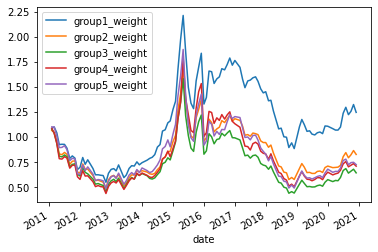

In [203]:
group_cum_returns.plot()

## Factor Combination

In [204]:
COMBINE_FACTORS = ['PE_TTM', 'PS_TTM']

In [205]:
def get_ic_series(factor, df_backtest=df_backtest):
    def wls_factor_resid(df):
        import statsmodels.formula.api as smf
        wls_result = smf.wls(formula = f"{factor} ~ 0 + market_value + C(pri_indus_code)", 
                        data=df, weights = df['market_value'] ** 0.5).fit()
        return wls_result.resid
    if f'{factor}_resid' not in df_backtest.columns:
        factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
        factor_resids = factor_resids.rename(f'{factor}_resid')
        df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)
    def cross_sectional_ic(df):
        return df[['next_period_return', f'{factor}_resid']].corr(method='spearman').iloc[0, 1]
    ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)
    return ic_series

In [206]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  group1_weight  group2_weight  \
date       stock                                                           
2011-01-31 000001.XSHE            0.033426       0.002786       0.000000   
           000002.XSHE            0.052368       0.000000       0.002786   
           000005.XSHE            0.013928       0.002786       0.000000   
           000006.XSHE            0.052368       0.000000       0.002786   
           000009.XSHE            0.006685       0.000000       0.000000   
...                                    ...            ...            ...   
2020-11-30 688368.XSHG            0.080820       0.000000       0.000000   
           688369.XSHG            0.080820       0.000000       0.000000   
           688388.XSHG            0.627775       0.000000       0.000000   
           688389.XSHG            0.627775       0.000000       0.000000   
           688399.XSHG            0.627775       0.000000       0.000000   

                  

In [207]:
#The multiprocessing takes forever, not sure why
#had to use for loop for now. Look into this later

# with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool: 
#     ic_series_results = pool.map( get_ic_series, COMBINE_FACTORS)
ic_series_results = [get_ic_series(factor).rename(factor) for factor in COMBINE_FACTORS] #around 8 seconds
df_ic_series = pd.concat(ic_series_results, axis=1)

In [208]:
df_ic_series

,PE_TTM,PS_TTM
date,,
2011-01-31,0.122038,-0.023049
2011-02-28,-0.108788,-0.226326
2011-03-31,-0.039691,-0.158952
2011-04-29,0.044145,-0.055560
2011-05-31,-0.005144,0.005217
...,...,...
2020-07-31,-0.070473,-0.053090
2020-08-31,-0.013264,-0.020628
2020-09-30,-0.039684,0.003087


In [209]:
hist_periods = 12
df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,0.017158,0.014609
2020-08-31,0.002643,0.004395
2020-09-30,-0.005247,-0.005529


In [210]:
#leave the computation for later
# A = np.arange(6).reshape(2,3) # 2 x 3, N = 2, T = 3
# S = pd.DataFrame(A).T.cov() #2 x 2
# np.expand_dims(A, 0)

In [211]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()
df_ic_cov_mat_series

PE_TTM    PS_TTM
date                                 
2011-01-31 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-02-28 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-03-31 PE_TTM       NaN       NaN
...                     ...       ...
2020-09-30 PS_TTM  0.003591  0.003734
2020-10-30 PE_TTM  0.007071  0.003916
           PS_TTM  0.003916  0.004975
2020-11-30 PE_TTM  0.006446  0.002633
           PS_TTM  0.002633  0.004430

[224 rows x 2 columns]

#### maximize the ICIR values on a single rebalancing date

In [212]:
w = np.array([0.5, 0.5])

In [213]:
pd.date_range(START_DATE, END_DATE)

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3653, freq='D')

In [214]:
df_ic_hist_mean = df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

In [215]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()

In [216]:
df_ic = df_ic_series[df_ic_series.index == '2020-09-30']
df_ic

,PE_TTM,PS_TTM
date,,
2020-09-30,-0.039684,0.003087


In [217]:
df_ic_cov_mat = df_ic_cov_mat_series[df_ic_cov_mat_series.index.get_level_values(0) == '2020-09-30']
df_ic_cov_mat

PE_TTM    PS_TTM
date                                 
2020-09-30 PE_TTM  0.007028  0.003591
           PS_TTM  0.003591  0.003734

In [218]:
w @ df_ic_cov_mat.values @ w.transpose()

0.004485995403002523

In [219]:
w.transpose() @ df_ic.values.flatten()

-0.018298650295172234

In [220]:
def get_ic_ir(factor_weights):
    ic_mean = factor_weights.transpose() @ df_ic.values.flatten()
    ic_var = factor_weights @ df_ic_cov_mat.values @ factor_weights.transpose()
    return ic_mean / (ic_var ** 0.5)

In [221]:
df_ic_cov_mat.shape

(2, 2)

In [222]:
num_factors = len(COMBINE_FACTORS)
opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
opt_factor_weight = opt_result.x

In [223]:
opt_factor_weight

array([0., 1.])

#### optimal factor weight on all rebalancing dates

In [224]:
df_ic_series.rolling(12).apply(lambda df: df.mean() )

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,0.017158,0.014609
2020-08-31,0.002643,0.004395
2020-09-30,-0.005247,-0.005529


In [225]:
df_ic_series.index[hist_periods:]

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-30', '2012-05-31',
               '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28',
               '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-29', '2013-05-31', '2013-06-28',
               '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31',
               '2013-11-29', '2013-12-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31',
               '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28',
               '2014-12-31', '2015-01-30', '2015-02-27', '2015-03-31',
               '2015-04-30', '2015-05-29', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30',
               '2015-12-31', '2016-01-29', '2016-02-29', '2016-03-31',
               '2016-04-29', '2016-05-31', '2016-06-30', '2016-07-29',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
      

In [226]:
def get_opt_factor_weight_by_date(date): 
    df_ic = df_ic_series[df_ic_series.index == date]
    df_pred_ic = df_ic.rolling(hist_periods).mean()
    print('11111')
    print(df_pred_ic)
    df_pred_ic_cov_mat = df_ic.rolling(hist_periods).cov()
    print('a')
    def get_ic_ir(factor_weights):
        combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
        combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
        combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
        return combined_ir
    print('b')
    opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
    print('c')
    opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
    print('d')
    return opt_result.x

In [227]:
valid_dates = df_ic_series.index[hist_periods:]
results = [get_opt_factor_weight_by_date(date) for date in valid_dates]

11111
            PE_TTM  PS_TTM
date                      
2012-01-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-02-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-03-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-05-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-06-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-07-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-08-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-09-28     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-10-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-11-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date             

In [228]:
results #TBD: not sure why the optimization is not working, debug

[array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),


In [ ]:
#we cannot use pandas.rolling.apply(func) because rolling.apply is different from groupby.apply -- it cannot take a dataframe as the parameter


# num_factors = len(COMBINE_FACTORS)
# def get_opt_factor_weight_by_date(ic_series: pd.Series): 
#     df = df_ic_series.loc[ic_series.index, :]
#     df_pred_ic = df.mean()
#     print('11111')
#     print(df_pred_ic)
#     df_pred_ic_cov_mat = df.cov()
#     print('a')
#     def get_ic_ir(factor_weights):
#         combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
#         combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
#         combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
#         return combined_ir
#     print('b')
#     opt_result = scipy.optimize.minimize(
#                 lambda w: -get_ic_ir(w),
#                 np.array([1 / num_factors] * num_factors),
#                 bounds=[(0, 1) for i in range(num_factors)],
#                 constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
#             )
#     print('c')
#     date = df.index[0]
#     opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
#     print('d')
#     return opt_result.x

# df_ic_series.rolling(12).apply(get_opt_factor_weight_by_date)

### Missing Value Analysis(Done by Hankle and Jason)

In [ ]:
# Calculate percentage of data missing for each stock, 
# record all stocks that have more than 50% data missing
missing = backtest_price_data.isnull().sum().reset_index().rename(columns = {0:'missNum'}).sort_values('missNum')
missing['missRate'] = missing['missNum']/backtest_price_data.shape[0]
missing = missing[missing.missRate > 0.5].sort_values(by = 'missRate', ascending=False)
missing

NameError: name 'backtest_price_data' is not defined

In [ ]:
# Drop entries of stock with more than 50% data missing
removed_code = missing['index'].to_list()
backtest_codes = list(set(backtest_price_data.columns) - set(removed_code))

# FIXME: dropping stock data at the end of 10 yrs testing period is a form of look ahead bias
backtest_price_data = backtest_price_data[backtest_codes] 

In [ ]:
# Store processed price data to HDF files
price_data.to_hdf('full price data.h5',key='price')
backtest_price_data.to_hdf('10-year non-ST price data.h5', key='price')

#### Download factor data

In [ ]:
# Fill in factors intended to download, startdate, and enddate
# to bulk download. Downloaded file is saved to './data/factor'.
# Refer to Ricequant doc for all available factors:
# https://www.ricequant.com/welcome/rqdata 


factor_list = ['OBOS']
startdate = '20201001'
enddate = '20211001'

for factor in []:
    dl.download_factor_data(price_data.columns, factor, '20201001', '20211001') 

#### Missing value analysis of factor data

In [ ]:
dl.load_factor_data('OBOS')

OBOS
order_book_id date            
000001.XSHE   2021-08-31  -4.0
              2021-09-01  -4.0
              2021-09-02  -2.0
              2021-09-03  -2.0
              2021-09-06   0.0
              2021-09-07   0.0
              2021-09-08   0.0
              2021-09-09   0.0
              2021-09-10   2.0
              2021-09-13   2.0
              2021-09-14   0.0
              2021-09-15   0.0
              2021-09-16  -2.0
              2021-09-17  -2.0
              2021-09-22  -4.0
              2021-09-23  -6.0
              2021-09-24  -6.0
              2021-09-27  -4.0
              2021-09-28  -4.0
              2021-09-29  -2.0
              2021-09-30  -2.0